# Step 1: Creating Tokens

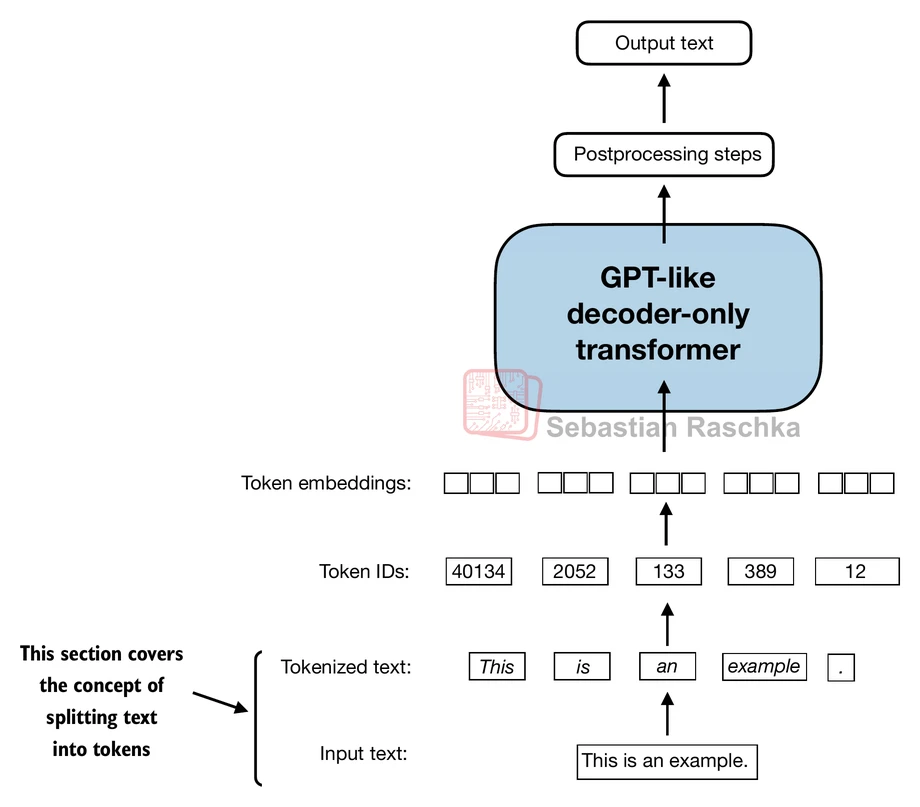

In [1]:
with open("the verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total No of Characters:", len(raw_text))
print(raw_text[:99])

Total No of Characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


Our goal is to tokenize the text into individual words and special characters that can then turn into embedding for LLM training

We will use regular expression to split on whitespaces

In [2]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)  # We split where ever white spaces exist
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


We don't only want to split on whitespaces but also commas and periods, so let's modify the regular expression to do that as well

In [3]:
result = re.split(r'([,.]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


A small remaining issue is that the list still include whitespace characters

In [4]:
cleaned_result = []

for x in result:

    # remove any extra space from the item

    stripeed_item = x.strip()

    if stripeed_item !='':
        cleaned_result.append(x)

result = cleaned_result
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


REMOVING WHITESPACES OR NOT

When developing a simple tokenizer, whether we should encode whitespaces as separate characters or just remove them depends on our application and its requirements. Removing whitespaces reduces the memory and computing requirements. However, keeping whitespaces can be useful if we train models that are sensitive to the exact structure of the text (for example, Python code, which is sensitive to indentation and spacing). Here, we remove whitespaces for simplicity and brevity of the tokenized outputs. Later, we will switch to a tokenization scheme that includes whitespaces.

The tokenization scheme we devised above works well on the simple sample text. Let's modify it a bit further so that it can also handle other types of punctuation, such as question marks, quotation marks, and the double-dashes we have seen earlier in the first 100 characters of Edith Wharton's short story, along with additional special characters:

In [5]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)

cleaned_result = []

for x in result:

    # remove any extra space from the item

    stripeed_item = x.strip()

    if stripeed_item !='':
        cleaned_result.append(x)

result = cleaned_result
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


Now that we got a basic tokenizer working, let's apply it to Verdict text file

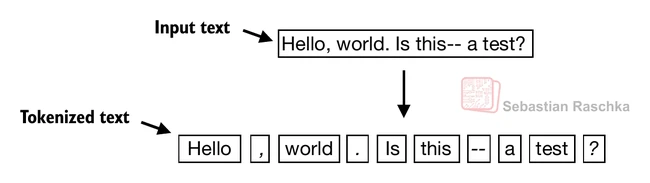

In [6]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)

cleaned_result = []

for x in preprocessed:

    # remove any extra space from the item

    stripeed_item = x.strip()

    if stripeed_item !='':
        cleaned_result.append(x)

preprocessed = cleaned_result
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [7]:
print(len(preprocessed))

4690
